<a href="https://colab.research.google.com/github/angelohafner/linguagem-de-programacao-udesc/blob/main/state_space_solve_ivp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State-Space Modeling and Simulation (solve_ivp)

This notebook explains **state-space** representation and shows how to simulate linear and nonlinear systems using Python's `scipy.integrate.solve_ivp`. We convert classical 2nd-order ODE models to the state-space form.

**State-space (continuous-time):**

- Linear time-invariant (LTI):  x' = A x + B u,   y = C x + D u
- Nonlinear: x' = f(t, x, u),  y = g(t, x, u)

Where x is the state vector, u is the input, and y is the output.

## 1. Helpers: time grid, simulators for LTI and nonlinear

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def uniform_time_grid(t0, tf, n_points):
    # Create a uniform time grid for evaluation
    return np.linspace(t0, tf, n_points)

def simulate_lti(A, B, C, D, u_fun, x0, t_span, t_eval, method='RK45'):
    # Simulate LTI system x' = A x + B u, y = C x + D u using solve_ivp
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)
    C = np.array(C, dtype=float)
    D = np.array(D, dtype=float)
    x0 = np.array(x0, dtype=float)

    def rhs(t, x):
        u = np.array(u_fun(t), dtype=float)
        dx = A.dot(x) + B.dot(u)
        return dx

    sol = solve_ivp(rhs, t_span, x0, t_eval=t_eval, method=method)
    # Output
    U = np.array([u_fun(ti) for ti in sol.t], dtype=float).T
    if U.ndim == 1:
        U = U.reshape(1, U.shape[0])
    Y = C.dot(sol.y) + D.dot(U)
    return sol.t, sol.y, Y

def simulate_nonlinear(f, g, x0, t_span, t_eval, method='RK45'):
    # Simulate nonlinear system x' = f(t, x), y = g(t, x)
    x0 = np.array(x0, dtype=float)

    def rhs(t, x):
        return np.array(f(t, x), dtype=float)

    sol = solve_ivp(rhs, t_span, x0, t_eval=t_eval, method=method)
    if g is None:
        Y = None
    else:
        Y = np.array([g(ti, sol.y[:, i]) for i, ti in enumerate(sol.t)], dtype=float).T
        if Y.ndim == 1:
            Y = Y.reshape(1, Y.shape[0])
    return sol.t, sol.y, Y

def plot_series(t, series, labels, title_text):
    # Plot multiple series on one figure (each row in 'series')
    plt.figure()
    for i in range(series.shape[0]):
        plt.plot(t, series[i, :], label=labels[i])
    plt.xlabel('t')
    plt.ylabel('value')
    plt.title(title_text)
    plt.legend()
    plt.grid(True)
    plt.show()


## 2. Mass–Spring–Damper as State-Space (with input force)
Equation: m y'' + c y' + k y = F(t)

Choose states: x1 = y (position), x2 = y' (velocity)

x' = [ x2,  -(c/m) x2 - (k/m) x1 + (1/m) F(t) ]^T

In matrix form (LTI): x' = A x + B u,  y = C x + D u

A = [[0, 1], [-(k/m), -(c/m)]],  B = [[0], [1/m]],  y = x1 (C = [1, 0], D = [0])

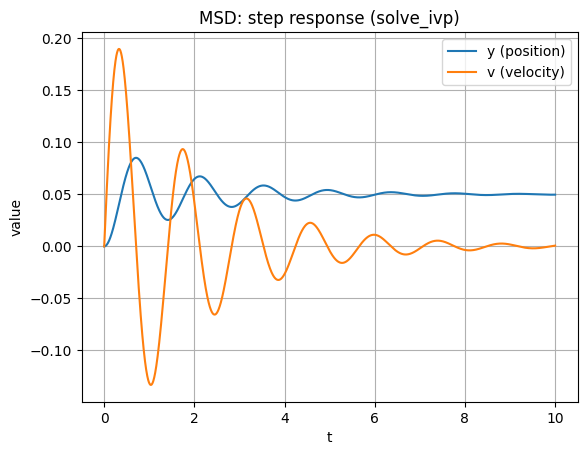

In [2]:
m = 1.0
c = 1.0
k = 20.0
t0 = 0.0
tf = 10.0
t_eval = uniform_time_grid(t0, tf, 2000)
x0 = [0.0, 0.0]  # start at rest

def step_force(t):
    # Step of amplitude 1 after t >= 0
    return [1.0]

A = [[0.0, 1.0], [-(k / m), -(c / m)]]
B = [[0.0], [1.0 / m]]
C = [[1.0, 0.0], [0.0, 1.0]]  # output both y and v for visualization
D = [[0.0], [0.0]]

t_ms, X_ms, Y_ms = simulate_lti(A, B, C, D, step_force, x0, (t0, tf), t_eval)
plot_series(t_ms, Y_ms, ['y (position)', 'v (velocity)'], 'MSD: step response (solve_ivp)')


## 3. Series RLC as State-Space (with input voltage)
Let states: x1 = q (capacitor charge), x2 = i (current). Input u = Vin(t).

Equations: q' = i,   i' = (Vin - R i - (1/C) q) / L

A = [[0, 1], [-(1/(L*C)), -(R/L)]],  B = [[0], [1/L]]
Outputs: capacitor voltage Vc = q/C, current i = x2  ->  y = [Vc, i]^T, so C and D chosen accordingly.

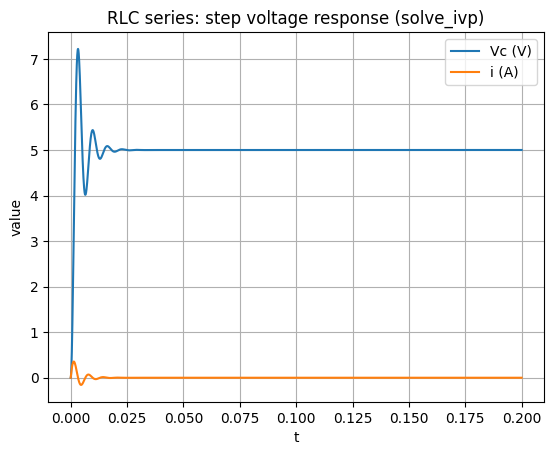

In [3]:
Lv = 10e-3
Rv = 5.0
Cv = 100e-6
t0 = 0.0
tf = 0.2
t_eval = uniform_time_grid(t0, tf, 4000)
x0 = [0.0, 0.0]

def Vin(t):
    return [5.0]

A = [[0.0, 1.0], [-(1.0 / (Lv * Cv)), -(Rv / Lv)]]
B = [[0.0], [1.0 / Lv]]
C = [[1.0 / Cv, 0.0], [0.0, 1.0]]  # outputs [Vc, i]
D = [[0.0], [0.0]]

t_rlc, X_rlc, Y_rlc = simulate_lti(A, B, C, D, Vin, x0, (t0, tf), t_eval)
plot_series(t_rlc, Y_rlc, ['Vc (V)', 'i (A)'], 'RLC series: step voltage response (solve_ivp)')


## 4. Simple Pendulum as **Nonlinear** State-Space
States: x1 = theta, x2 = omega. No input (u=0).

Nonlinear model: theta' = omega,  omega' = -(g/L) sin(theta)

Linearized near small angles: A = [[0, 1], [-(g/L), 0]]

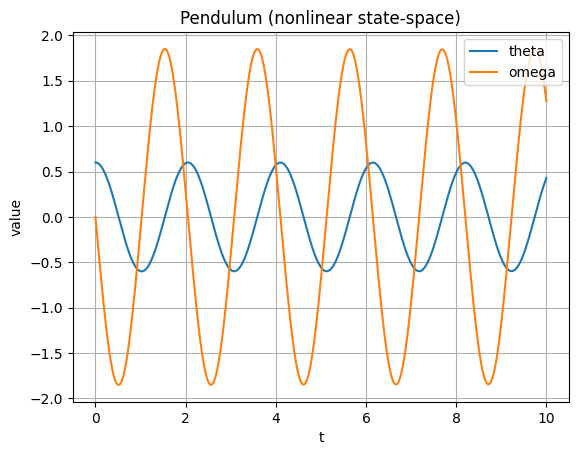

In [4]:
g = 9.81
L = 1.0
t0 = 0.0
tf = 10.0
t_eval = uniform_time_grid(t0, tf, 3000)
x0 = [0.6, 0.0]

def f_pend(t, x):
    theta = x[0]
    omega = x[1]
    dtheta = omega
    domega = -(g / L) * np.sin(theta)
    return [dtheta, domega]

def g_pend(t, x):
    # output both states
    return [x[0], x[1]]

t_pen, X_pen, Y_pen = simulate_nonlinear(f_pend, g_pend, x0, (t0, tf), t_eval)
plot_series(t_pen, Y_pen, ['theta', 'omega'], 'Pendulum (nonlinear state-space)')


## 5. Projectile with Linear Drag (State-Space, 2D)
States: x = [px, py, vx, vy]. Input u = 0. Outputs y = [px, py].

Model: px' = vx, py' = vy, vx' = -(k/m) vx, vy' = -g -(k/m) vy.


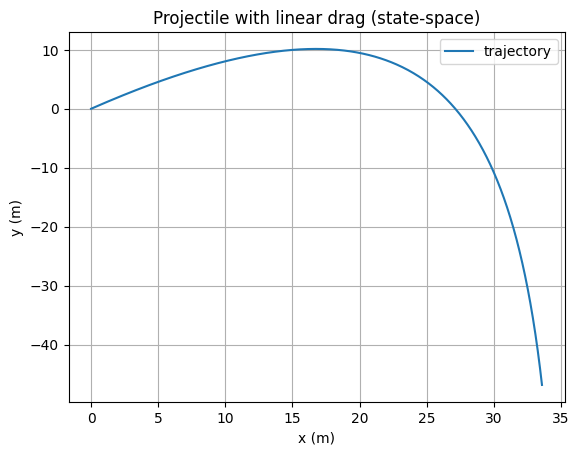

In [5]:
mproj = 0.2
kdrag = 0.1
g = 9.81
t0 = 0.0
tf = 6.0
t_eval = uniform_time_grid(t0, tf, 600)
v0 = 25.0
angle = 45.0 * np.pi / 180.0
x0 = [0.0, 0.0, v0 * np.cos(angle), v0 * np.sin(angle)]

def f_proj(t, x):
    px = x[0]
    py = x[1]
    vx = x[2]
    vy = x[3]
    dpx = vx
    dpy = vy
    dvx = -(kdrag / mproj) * vx
    dvy = -g - (kdrag / mproj) * vy
    return [dpx, dpy, dvx, dvy]

def g_proj(t, x):
    return [x[0], x[1]]

t_pr, X_pr, Y_pr = simulate_nonlinear(f_proj, g_proj, x0, (t0, tf), t_eval)
plt.figure()
plt.plot(Y_pr[0, :], Y_pr[1, :], label='trajectory')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Projectile with linear drag (state-space)')
plt.legend()
plt.grid(True)
plt.show()


## 6. Controllability and Observability (LTI)
For LTI systems, controllability and observability are checked via the ranks of:
- Controllability matrix  Mc = [B, A B, A^2 B, ...]
- Observability matrix    Mo = [C^T, (C A)^T, (C A^2)^T, ...]^T
Full state dimension rank implies controllable/observable.

In [6]:
def controllability_matrix(A, B):
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)
    n = A.shape[0]
    blocks = []
    Ak = np.eye(n)
    for k in range(n):
        blocks.append(Ak.dot(B))
        Ak = Ak.dot(A)
    M = np.concatenate(blocks, axis=1)
    return M

def observability_matrix(A, C):
    A = np.array(A, dtype=float)
    C = np.array(C, dtype=float)
    n = A.shape[0]
    blocks = []
    Ak = np.eye(n)
    for k in range(n):
        blocks.append(C.dot(Ak))
        Ak = Ak.dot(A)
    M = np.concatenate(blocks, axis=0)
    return M

# Check for the MSD example (position output only)
A_msd = [[0.0, 1.0], [-(k / m), -(c / m)]]
B_msd = [[0.0], [1.0 / m]]
C_msd = [[1.0, 0.0]]
Mc = controllability_matrix(A_msd, B_msd)
Mo = observability_matrix(A_msd, C_msd)
rank_Mc = np.linalg.matrix_rank(Mc)
rank_Mo = np.linalg.matrix_rank(Mo)
print('MSD controllability rank =', rank_Mc)
print('MSD observability rank    =', rank_Mo)


MSD controllability rank = 2
MSD observability rank    = 2


## 7. Exercises
1) MSD with sinusoidal input F(t) = F0 * sin(Ω t): implement u_fun and compare resonance for different Ω.

2) RLC with square-wave input: replace Vin(t) by a square wave and observe steady-state regime.

3) Pendulum with damping b: omega' = -(b/I) omega -(g/L) sin(theta). Compare to small-angle linear model.

4) Build A, B, C, D for a DC motor (armature) and simulate speed under a step voltage.
